In [1]:
from load_portfolios import *
import os
import pandas as pd
import numpy as np

#### Load Anomalies Portfolio

In [3]:
#### Managed Portfolios
filename = './Daily/managed_portfolios_anom_d_55.csv'
dropna_perc = 0.8 # could be 1, which leads to 41; if 0.5, leads to 55 (all)
dates_anomaly, re_anomaly, mkt_anomaly, names_anomaly = load_managed_portfolios(filename, drop_perc=dropna_perc)
# re_anomaly['r_mkt'] = mkt_anomaly
# re_anomaly.index = dates_anomaly
print(f'At dropna percent={dropna_perc}, there are {len(names_anomaly)} anomalies portfolios available.')

# #### Fama-French 25 Portfolios
# dates_ff25, ret_ff25, mkt_ff25, DATA_ff25, labels_ff25 = load_ff25(datapath='./')

# #### Fama-French Anomalies
# dates_ffa, ret_ffa, mkt_ffa, DATA_ffa = load_ff_anomalies(datapath='./')

At dropna percent=0.8, there are 53 anomalies portfolios available.


#### Understand Code

In [ ]:
from cross_validate import *
import matplotlib.pyplot as plt

In [ ]:
def demarket(r, mkt, b=None):
    # If b (beta) is not provided, compute it
    if b is None:
        # Create a design matrix with intercept (column of ones) and market returns
        rhs = np.column_stack([np.ones(mkt.shape[0]), mkt])
        # Solve for beta using least squares
        b, _ = np.linalg.lstsq(rhs, r, rcond=None)[0:2] 
        b = b[1, :]
    # De-market returns (residuals after removing market component)
    rme = r - np.outer(mkt, b)
    return rme, b

In [49]:
def plot_dof(df, x, p):
    """
    degrees of freedom <-> kappa plot
    
    Parameters:
    - df: Degrees of freedom data to be plotted on the y-axis.
    - x: Data to be plotted on the x-axis.
    - p: Dictionary containing various plot parameters.
    """
    
    # Open a new figure
    plt.figure()
    
    # Plot
    plt.plot(x, df, linewidth=p['line_width'])
    
    # Log-scale adjustments
    if p['L1_log_scale']:
        plt.yscale('log')
        plt.yticks([tick + 1e-12 for tick in plt.yticks()[0]])  # Adding a small constant
    
    if p['L2_log_scale']:
        plt.xscale('log')
        plt.xticks([tick + 1e-12 for tick in plt.xticks()[0]])  # Adding a small constant
    
    # Labels and grid
    plt.xlabel(p['xlbl'], fontsize=12, labelpad=10, fontweight='bold')
    plt.ylabel('Effective degrees of freedom', fontsize=12, labelpad=10, fontweight='bold')
    plt.grid(True)
    
    # Setting x-axis limits
    plt.xlim([min(x), max(x)])
    
    # Show plot
    if p['show_plot']:
        plt.show()

    if p['results_export']:
        plt.savefig('results_export/degrees_of_freedom.png', dpi=300, bbox_inches='tight')

def plot_L2coefpaths(x, phi, iL2opt, anomalies, ylbl, p):
    """
    L2 coefficients paths plot
    
    Parameters:
    - x: Data for the x-axis.
    - phi: Coefficient path data.
    - iL2opt: Optimal index for regularization.
    - anomalies: Names for legends.
    - ylbl: Label for the y-axis.
    - p: Dictionary containing various plot parameters.
    """
    
    # Decide sorting location
    if p['L2_sort_loc'] == 'opt':
        iSortLoc = iL2opt
    elif p['L2_sort_loc'] == 'OLS':
        iSortLoc = 0
    else:
        raise ValueError('Unknown option')
    
    # Sorting mechanism
    if p['n'] > p['L2_max_legends']:
        I = np.argsort(-np.abs(phi[:, iSortLoc]))  # Descending sort by absolute value
    else:
        I = np.argsort(-phi[:, iSortLoc])  # Descending sort
    
    # Open a new figure
    plt.figure()
    
    # Plot
    for i in I:
        plt.plot(x, phi[i, :], linewidth=p['line_width'])
    
    # Log-scale adjustment
    if p['L2_log_scale']:
        plt.xscale('log')
        plt.xticks([tick + 1e-16 for tick in plt.xticks()[0]])
    
    # Labels and grid
    plt.xlabel(p['xlbl'], fontsize=12, labelpad=10, fontweight='bold')
    plt.ylabel(ylbl, fontsize=12, labelpad=10, fontweight='bold')
    plt.grid(True)
    
    # Legend
    idx = I[:min(p['L2_max_legends'], len(I))]
    plt.legend([anomalies[i] for i in idx], loc=p['legend_loc'], fontsize=p['font_size'], bbox_to_anchor=(1.05, 1))
    
    # Dashed line at optimal regularization
    plt.plot([x[iL2opt], x[iL2opt]], [np.min(phi), np.max(phi)], '--k')
    
    # x-axis limits
    plt.xlim([min(x), max(x)])
    
    # Show plot
    if p['show_plot']:
        plt.show()

    if p['results_export']:
        if ylbl == 'SDF Coefficient, $b$':
            plt.savefig('results_export/coefficients_paths.png', dpi=300, bbox_inches='tight')
        elif ylbl == 'SDF Coefficient $t$-statistic':
            plt.savefig('results_export/tstats_paths.png', dpi=300, bbox_inches='tight')


def plot_L2cv(x, objL2, p):
    """
    Plot SSE/objective & BIC as a function of degrees of freedom.
    
    Parameters:
    - x: Data for the x-axis.
    - objL2: Data for plotting objectives and possible other values.
    - p: Dictionary containing various plot parameters.
    """
    
    # Open a new figure
    plt.figure()
    
    # Plot In-sample (IS) and Out-of-Sample (OOS)
    plt.plot(x, objL2[:, 0], '--', linewidth=p['line_width'])  # IS
    plt.plot(x, objL2[:, 1], '-', linewidth=p['line_width'])  # OOS
    
    # Log-scale adjustment
    if p['L2_log_scale']:
        plt.xscale('log')
        plt.xticks([tick + 1e-16 for tick in plt.xticks()[0]])
    
    # Labels
    plt.xlabel(p['xlbl'], fontsize=12, labelpad=10, fontweight='bold')
    plt.ylabel(f"IS/OOS {p['sObjective']}", fontsize=12, labelpad=10, fontweight='bold')
    
    # Legends and plot +1, -1 standard error
    co = plt.gca().lines[-1].get_color()  # Getting color of last line plotted (OOS line)
    plt.plot(x, objL2[:, 1] + objL2[:, 3], ':', color=co, linewidth=1)  # +1 SE
    plt.plot(x, objL2[:, 1] - objL2[:, 3], ':', color=co, linewidth=1)  # -1 SE
    
    plt.legend(['In-sample', f"OOS {p['method']}", f"OOS {p['method']} +/- 1 s.e."],
               loc='upper right')
    
    # Grid, axis limits
    plt.grid(True)
    plt.ylim([0, max(0.1, min(10, 2*max(objL2[:, 1])))])
    plt.xlim([min(x), 2])
    
    # Show plot
    if p['show_plot']:
        plt.show()

    if p['results_export']:
        plt.savefig('results_export/cross_validation.png', dpi=300, bbox_inches='tight')



def table_L2coefs(phi, se, anomalies, p):
    """
    Function to display a table of largest coefficients and t-stats.

    Parameters:
    - phi: Coefficients.
    - se: Standard error.
    - anomalies: Anomaly descriptions.
    - p: Dictionary containing various parameters.
    """
    nrows = 10  # number of rows in the table to show
    
    # t-stats
    tstats = phi / se
    
    # by absolute tstats
    idx = np.argsort(np.abs(tstats))[::-1]
    
    # show only nrows items
    idx = idx[:nrows]
   
    # create a DataFrame
    data = {
        'Portfolio': [anomalies[i] for i in idx],
        'b': phi[idx],
        't_stat': np.abs(tstats[idx])
    }
    df = pd.DataFrame(data)
    
    # display table
    print(df)

    # export as a latex formatted table
    if p['results_export']:
        df.to_latex('results_export/coefficients_table.tex', index=False)

def regcov(r):
    """
    Compute the regularized covariance matrix of r.

    Parameters:
    - r: Input data matrix

    Returns:
    - X: Regularized covariance matrix
    """
    
    # Compute covariance matrix
    X = np.cov(r, rowvar=False)

    # Covariance regularization (with flat Wishart prior)
    T, n = r.shape
    a = n / (n + T)
    X = a * np.trace(X) / n * np.eye(n) + (1 - a) * X

    return X

In [ ]:
# Assign default values
parameters = {
    'gridsize': 100, 'method': 'CV', 'objective': 'CSR2', 'ignore_scale': False, 'kfold': 3, 
    'oos_test_date': dates_anomaly.iloc[-1], 'freq': 252,
    'plot_dof': True, 'plot_coefpaths': True, 'plot_objective': True,
    'line_width': 1.5, 'font_size': 10, 'L2_max_legends': 20, 'L2_sort_loc': 'opt', 'L1_log_scale': True, 'L2_log_scale': True,
    'legend_loc': 'best', 'results_export': False, 'show_plot': True
}

parameters["sObjective"] = 'Cross-sectional $R^2$' # the original code provides many other options, like SR, SDF RMSE, MVU, etc.
optfunc = max
tT0 = datetime.strptime(parameters["oos_test_date"].strftime("%Y-%m-%d"), "%Y-%m-%d")
re_anomaly.index = dates_anomaly.values
mkt_anomaly.index = dates_anomaly.values
mkt0 = mkt_anomaly.copy()

### Original codes intends to write oos but stops short
# de-market unconditionally
r0, _ = demarket(re_anomaly.loc[:tT0, :], mkt0.loc[:tT0])
# de-vol unconditionally: normalized return is rescaled to match the market’s volatility
r0 = r0.divide(r0.std(axis=0), axis=1).multiply(mkt0.std())
T, n = r0.shape
parameters['T'] = T
parameters['n'] = n

# no projection into pca space **

In [51]:
# Compute first and second moments
X = regcov(r0)
y = np.mean(r0, axis=0)
# global minimum variance portfolio: y'X^-1y; pinv(X) is the pseudo-inverse of X
w = np.dot(np.dot(y.T, np.linalg.pinv(X)), y) 

# Eigen-decomposition of X, but only need D and Q
_, D, Q = np.linalg.svd(X)
# Diagonal elements of D: the eigenvalues of X
d = np.sum(np.diag(D), axis=1)

# Inverse of X using the eigen-decomposition
tol = max(X.shape) * np.finfo(float).eps * np.linalg.norm(d, np.inf)
r1 = np.sum(d > tol) + 1
Q1 = Q[:, :r1]
s = d[:r1]
s2 = 1 / np.sqrt(s)
s = 1 / s
Q1 = Q1.T
Xinv = np.dot(Q1 * s.reshape(1, -1), Q1.T)

# Options
parameters['xlbl'] = 'Root Expected SR$^2$ (prior), $\\kappa$'
parameters['Q'] = Q
parameters['d'] = d
parameters['Xinv'] = Xinv

# Functions to map L2pen <-> kappa
kappa2pen = lambda kappa, T, X, p: p['freq'] * np.trace(X) / T / (kappa ** 2)

In [52]:
def l2est(X, y, params, compute_errors=False): # returns L2 estimates and standard errors
    l = params['L2pen']
    if compute_errors:
        Xinv = np.linalg.inv(X + l * np.eye(X.shape[0]))
        
        b = np.dot(Xinv, y)
        se = np.sqrt(1 / params['T'] * np.diag(Xinv))
    else:
        # Solve a system of linear equations instead if errors are not needed
        b = np.linalg.solve(X + l * np.eye(X.shape[0]), y)
        se = np.full(X.shape[0], np.nan)

    return b, params, se

In [53]:
# Search over penalities
lr = np.arange(1, 22)  # equivalent of 1:21 in MATLAB
lm = 1

z = np.empty((n, len(lr)))
z.fill(np.nan)

for i in lr:
    params = parameters.copy()  # Make a copy of p to avoid modifying the original
    params['L2pen'] = kappa2pen(2 ** (i - lm), T, X, parameters)
    z[:, i - 1] = l2est(X, y, params)[0]

# Coefficient stabilize condition
mean_val = np.mean(np.abs((z[:, 1:] - z[:, :-1])) / (1 + np.abs(z[:, :-1])), axis=0) > 0.01
x_rlim = np.nonzero(mean_val)[0]

# Use the left and right points to define the support and create a finer grid on this support
x = np.logspace(np.log10(2**x_rlim[-1]), np.log10(0.01), parameters['gridsize']) # creates 100 points here
l = [kappa2pen(val, T, X, parameters) for val in x]
lCV = [val / (1 - 1 / parameters['kfold']) for val in l]  
nl = len(l) # number of lambda values of the grid

In [54]:
# Estimate the L2 model
params = parameters.copy() # Make a copy of p to avoid modifying the original

# Create placeholders for outputs
phi = np.full((n, nl), np.nan)
se = np.full_like(phi, np.nan)
objL2 = np.full((nl, 4), np.nan)
objL2_folds = np.full((nl, params['kfold']), np.nan)  # Assuming params['kfold'] is the number of folds
MVE = [None] * nl

for i in range(nl):
        # Estimate parameters at each grid point
        params['L2pen'] = l[i]
        # Note: You need to define the l2est function in Python or provide its MATLAB code for translation
        phi[:, i], _, se[:, i] = l2est(X, y, params, True)

        # Cross validate estimated parameters
        params['L2pen'] = lCV[i]
        # Note: You need to define the cross_validate function in Python or provide its MATLAB code for translation
        objL2[i, :], params, objL2_folds_ = cross_validate(l2est, dates_anomaly.values, r0, params)
        objL2_folds[i, :] = objL2_folds_[:, 1] # Python is 0-indexed

        # Store OOS MVE portfolios for each CV run
        MVE[i] = params['cv_MVE']

# Effective degrees of freedom
d_dim = d.shape[0]
df = np.sum(d.reshape(d_dim,1) / (d.reshape(d_dim,1) + np.array(l).reshape(1,100)), axis=0)


In [55]:
objL2opt = optfunc(objL2[:, 1])
if optfunc == max:
    iL2opt = objL2[:, 1].argmax()
if optfunc == min:
    iL2opt = objL2[:, 1].argmin()
bL2 = phi[:, iL2opt]
parameters['bL2'] = bL2
parameters['R2oos'] = objL2opt
L2optKappa = x[iL2opt]

# MVE portfolios for each fold at the optimal level of shrinkage [flatten into single time-series]
MVEopt = MVE[iL2opt]

# Return coefficients paths, degrees of freedom, and objective's value
parameters['coeffsPaths'] = phi
parameters['objL2_IS'] = objL2[:, 0]
parameters['objL2_OOS'] = objL2[:, 1]
z = np.concatenate([MVEopt[key] for key in MVEopt], axis=0)
parameters['optimal_model_L2'] = {
    'coefficients': bL2,
    'objective': objL2opt,
    'kappa': L2optKappa,
    'SR': np.mean(z) / np.std(z) * np.sqrt(parameters['freq'])
}
estimates = parameters

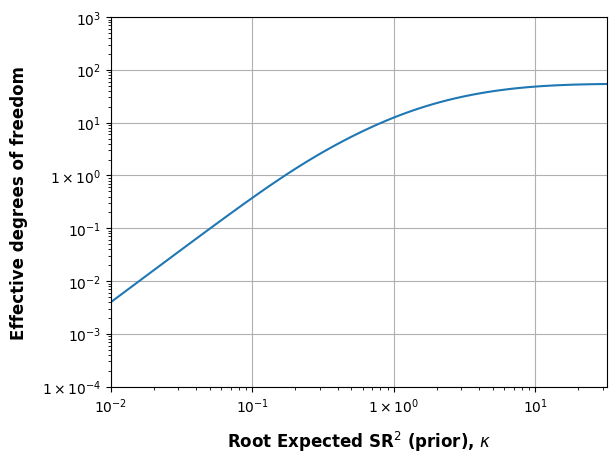

In [57]:
if parameters['plot_dof']:  # plot degrees of freedom
    plot_dof(df, x, parameters)

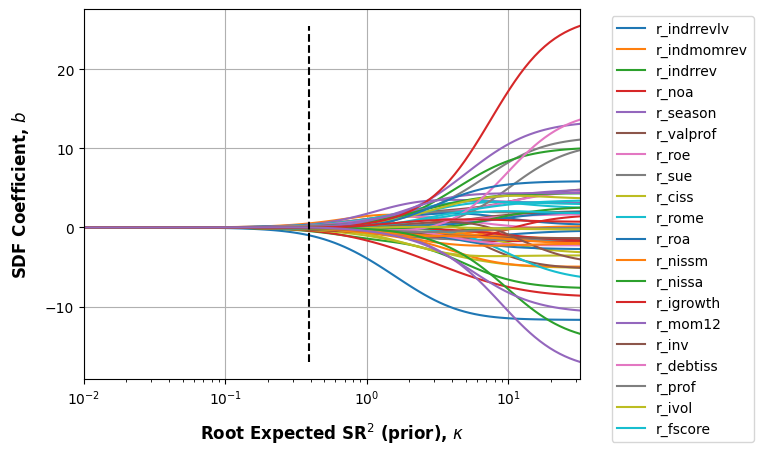

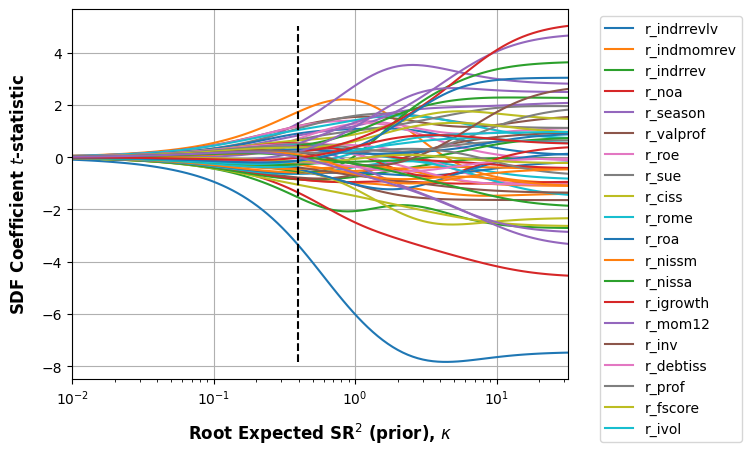

In [58]:
# SDF 2nd moment constraint (L2) coefficients paths
if parameters['plot_coefpaths']:
    # plot coefficients
    plot_L2coefpaths(x, phi, iL2opt, names_anomaly, 'SDF Coefficient, $b$', parameters)
    # plot t-stats
    plot_L2coefpaths(x, phi/se, iL2opt, names_anomaly, 'SDF Coefficient $t$-statistic', parameters)

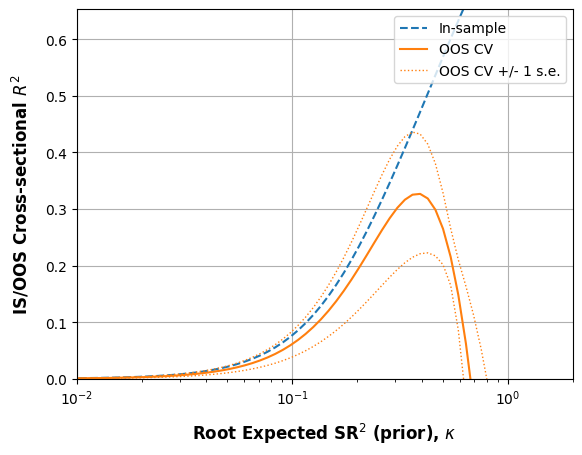

In [59]:
# L2 Cross-Validation/BIC plot
if parameters['plot_objective']:
    plot_L2cv(x, objL2, parameters)

In [60]:
# output table with coefficient & tstats estimates
table_L2coefs(phi[:, iL2opt], se[:, iL2opt], names_anomaly, parameters)

     Portfolio         b    t_stat
0  r_indrrevlv -0.996873  3.333491
1  r_indmomrev  0.517109  1.723705
2    r_indrrev -0.458936  1.529654
3        r_noa -0.402070  1.343006
4     r_season  0.383705  1.281503
5    r_valprof  0.358218  1.184591
6        r_roe  0.357392  1.182594
7        r_sue  0.328153  1.091170
8       r_ciss -0.318827  1.049471
9       r_rome  0.316084  1.036021
